In [1]:
import os

os.chdir("..")

In [2]:
import gc
import os
import warnings

import anndata as ad
import scanpy as sc

# Local imports
from tardis._mymodel import MyModel

## DATA LOADING

In [3]:
DATA_PATH = "./data/dataset_subset_age_1.h5ad"
assert os.path.isfile(DATA_PATH), f"File not already exist: `{DATA_PATH}`"
adata = ad.read_h5ad(DATA_PATH)

In [4]:
display(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

AnnData object with n_obs × n_vars = 21521 × 4096
    obs: 'handle_anndata', 'study', 'sample_ID', 'organ', 'age', 'cell_type', 'lane_ID', 'author_batch', 'institute', 'study_PI', 'doi', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'anatomical_region', 'anatomical_region_level_2', 'sex', 'sex_inferred', 'subject_type', 'sample_status', 'sample_cultured', 'protocol_tissue_dissociation', 'cell_enrichment', 'library_platform', 'strand_sequence', 'sequencing_platform', 'reads_processing', 'biological_unit', 'reference_genome', 'reference_genome_ensembl_release', 'concatenated_integration_covariates'
    var: 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'highly_variable', 'hvg', 'log1p', 'unification'

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


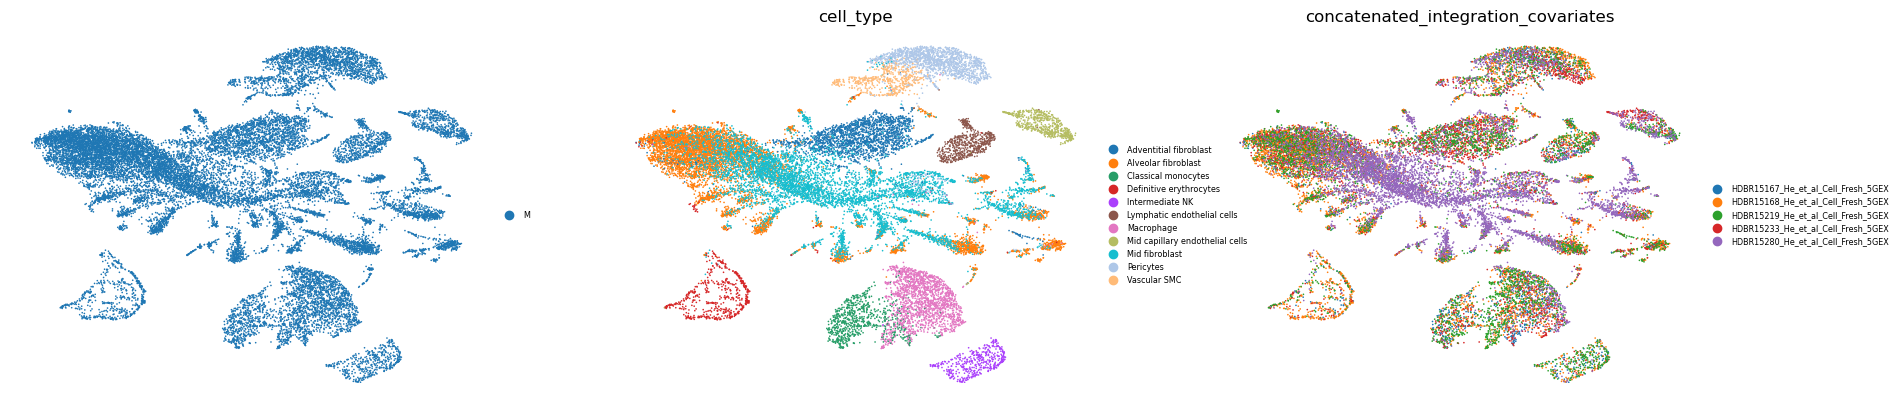

In [5]:
metadata_of_interest = "sex"

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        adata,
        color=[
            metadata_of_interest,
            "cell_type",
            "concatenated_integration_covariates",
        ],
        ncols=3,
        frameon=False,
        title="",
        legend_fontsize="xx-small",
    )
del adata
gc.collect();

In [6]:
adata = ad.read_h5ad(DATA_PATH)


# Hyperparameters of the model
n_hidden = 512
n_layers = 3
n_latent = 20
gene_likelihood = "nb"
dropout_rate = 0.1

# Training parameters
max_epochs = 200

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    MyModel.setup_anndata(
        adata, layer=None, batch_key="concatenated_integration_covariates"
    )
    vae = MyModel(
        adata,
        n_hidden=n_hidden,
        n_layers=n_layers,
        n_latent=n_latent,
        gene_likelihood=gene_likelihood,
        dropout_rate=dropout_rate,
    )
    vae.train(max_epochs=max_epochs)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 200/200: 100%|██████████| 200/200 [26:41<00:00,  7.83s/it, v_num=1, train_loss_step=205, train_loss_epoch=174]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [26:41<00:00,  8.01s/it, v_num=1, train_loss_step=205, train_loss_epoch=174]


In [8]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = vae.get_latent_representation()

In [9]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


/Users/aleynakara/mamba/envs/tardis_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


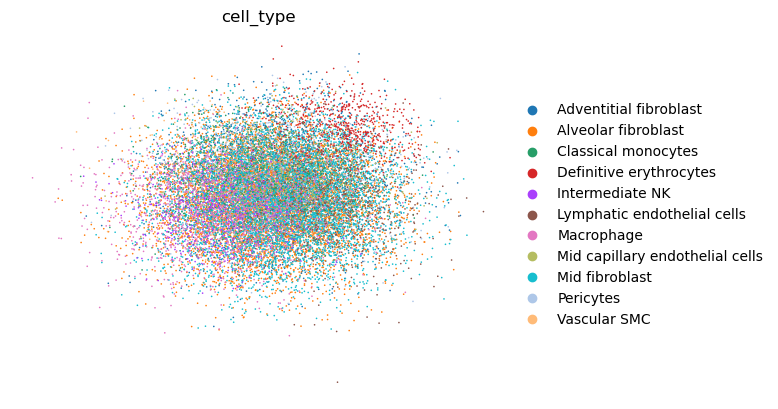

In [22]:
sc.pl.embedding(
    adata, basis=SCVI_LATENT_KEY, color=["cell_type"], frameon=False, ncols=1
)